# 結果、考察
## クラスが少ないデータセットでは
### →TDとBUで差がない、手書き絵はBUも分類（むしろTDの方が悪い）
### 　しかし、バックグラウンドに市松模様などある場合TDで分類できる、BUは分類できない
### 　よって、バックグラウンドのテクスチャーに対してはTDが有効
## ↓
### 　そもそもクラスが少ないとテクスチャー情報を多くは必要としない？
## クラスの多い（分類に多くのテクスチャー情報が必要）ImageNetでは手書き分類どうなる？

# 以降、現状までの検証

In [104]:
import numpy as np
from matplotlib import pyplot as plt
# import cv2
import os
import tensorflow as tf
from PIL import Image, ImageOps

font_ylabel = 18
font_xlabel = 18
font_legend = 13
font_title = 18

In [105]:
# path to files
path = './output/gradcam/'    # gitより一段上の階層

layers = ['act_1', 'act_2', 'act_3', 'act_4']
gradcam = {}
y_pred = {}
datasets = ['MNIST', 'Fashion-MNIST']
grad_thres = np.arange(0, 1.1, 0.1)

for d in datasets:
    gradcam[d] = {}
    y_pred[d] = {}

Functions for computing the number of TP, FP, FN, TN between Grad-CAM heatmaps and thresholded objects; some other metrics are also extracted. For thresholding objects an empiricaly set thershold t=0.2 is used. For fairness only the samples correctly classified by both *BU* and *TD* networks are considered.

In [106]:
def get_metrics(x_val, y_val, gradcam, layers, y_pred, index=None):

    im_thres = 0.2
    grad_thres = np.arange(0, 1, 0.1)

    metrics = {}
    for l in layers:
        metrics[l] = {}
        UN = []
        IOU = []
        TP = []
        FP = []
        FN = []
        TN = []
        for g in grad_thres:
            un = []
            iou = []
            tp = []
            fp = []
            fn = []
            tn = []
            for i, grad in zip(range(len(gradcam)), gradcam):
                if index is not None:
                    ind = index[i]
                else:
                    ind = y_val == y_pred[i]
                inter = np.sum(np.logical_and(np.greater(grad[l][ind], g), np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2))
                un = np.sum(np.logical_or(np.greater(grad[l][ind], g), np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2))
                tp.append(inter)
                fp.append(np.sum(np.logical_and(np.greater(grad[l][ind], g), ~np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2)))
                fn.append(np.sum(np.logical_and(~np.greater(grad[l][ind], g), np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2)))
                tn.append(np.sum(np.logical_and(~np.greater(grad[l][ind], g), ~np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2)))
                iou.append(inter/un)
            
            IOU.append(np.array(iou))
            TP.append(np.array(tp))
            FP.append(np.array(fp))
            FN.append(np.array(fn))
            TN.append(np.array(tn))
            
        IOU = np.array(IOU)
        TP = np.array(TP)
        FP = np.array(FP)
        FN = np.array(FN)
        TN = np.array(TN)

        metrics[l]['IoU'] = IOU
        metrics[l]['TP'] = TP
        metrics[l]['FP'] = FP
        metrics[l]['FN'] = FN
        metrics[l]['TN'] = TN
                          
        metrics[l]['Pr'] = TP / (TP+FP)
        metrics[l]['Rec'] = TP / (TP+FN)
        metrics[l]['F1'] = 2* (metrics[l]['Pr'] * metrics[l]['Rec'])/(metrics[l]['Pr'] + metrics[l]['Rec'])
        metrics[l]['FPR'] = FP / (FP + TN)
        
    return metrics

def BUvsTD(x_val, y_val, gradcam, gradcam_td, y_pred, y_pred_td, layers):
    
    index = np.logical_and(y_val == y_pred, y_val == y_pred_td)
    
    bu_metrics = get_metrics(x_val, y_val, gradcam, layers, y_pred, index)
    td_metrics = get_metrics(x_val, y_val, gradcam_td, layers, y_pred_td, index)
    
    return bu_metrics, td_metrics

# Fashion-MNIST

In [107]:
(_, _), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_val.astype(np.float32)[..., np.newaxis]/255.0
print(x_val.shape, np.min(x_val), np.max(x_val))
class_labels = np.array(['top', 'trouser', 'pullover', 'dress', 'coat', 
                         'sandal', 'shirt', 'sneaker', 'bag', 'ankleboot'])

(10000, 28, 28, 1) 0.0 1.0


In [108]:
model = 'NIN-light'
npzfile = np.load(f'{path}NIN_light_FMNIST_gradcam.npz', allow_pickle=True)
gradcam[datasets[1]][model] = npzfile['arr_0']
y_pred[datasets[1]][model] = npzfile['arr_1']

model = 'NIN-light_TD'
npzfile = np.load(f'{path}NIN_light_TD_FMNIST_gradcam.npz', allow_pickle=True)
gradcam[datasets[1]][model] = npzfile['arr_0']
y_pred[datasets[1]][model] = npzfile['arr_1']

Visualizing extracted Grad-CAM heatmaps, this time for `act_1`. `act_1` corresponds to a shallow layer the *BU* filters are local, edge-detecting ones and the thus the heatmaps focus on fine details (edges) of the input. On the contrary, *TD* is focusing on coarser representations of the input.

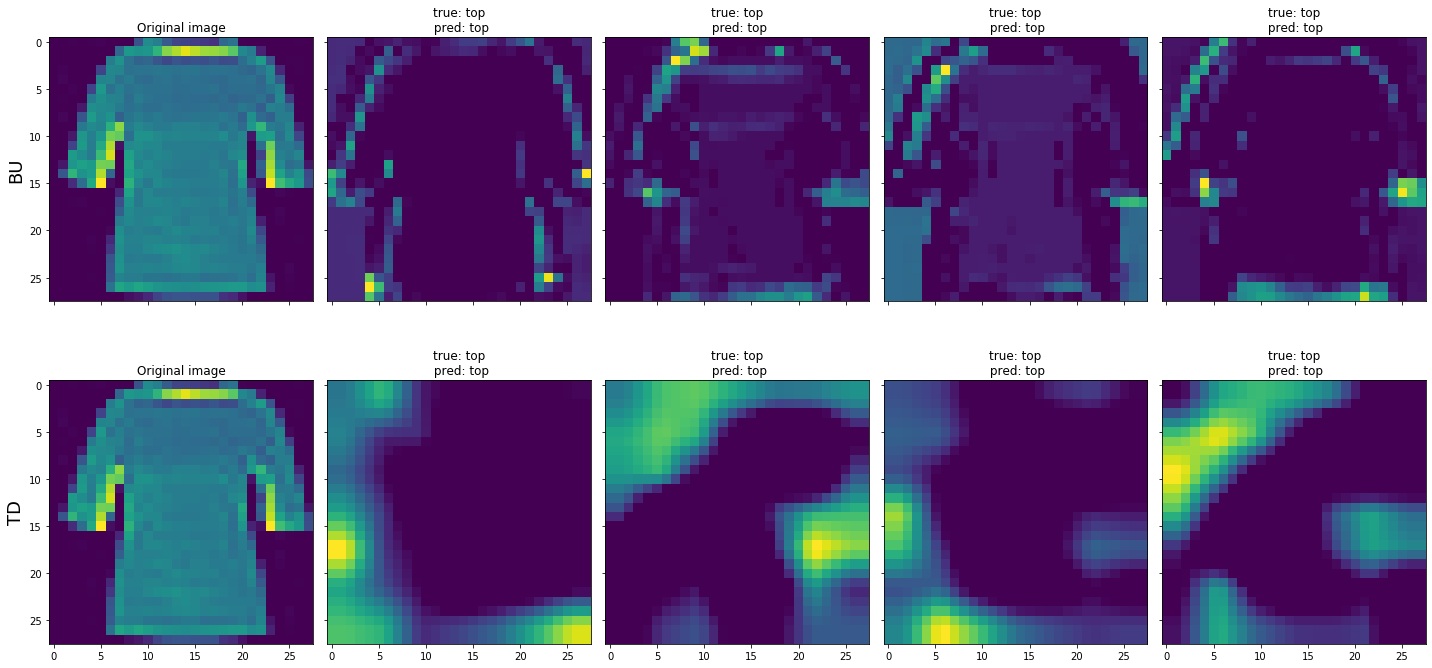

In [88]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 10),sharex=True, sharey=True)

mbu = 'NIN-light'
mtd = 'NIN-light_TD'
layer = 'act_1'

ii = int(np.random.rand() * len(x_val))

ax[0,0].imshow(x_val[ii,:,:,0])
ax[1,0].imshow(x_val[ii,:,:,0])
ax[0,0].set_title("Original image")
ax[1,0].set_title("Original image")

for i in range(4):
    ax[0,i+1].imshow(gradcam[datasets[1]][mbu][i][layer][ii])
    ax[1,i+1].imshow(gradcam[datasets[1]][mtd][i][layer][ii])
    ax[0,0].set_ylabel("BU", fontsize=font_ylabel)
    ax[1,0].set_ylabel("TD", fontsize=font_ylabel)
    ax[0,i+1].set_title(f"true: {class_labels[y_val[ii]]}\n pred: {class_labels[y_pred[datasets[1]][mbu][i][ii]]}")
    ax[1,i+1].set_title(f"true: {class_labels[y_val[ii]]}\n pred: {class_labels[y_pred[datasets[1]][mtd][i][ii]]}")
fig.tight_layout()

## 最後のact

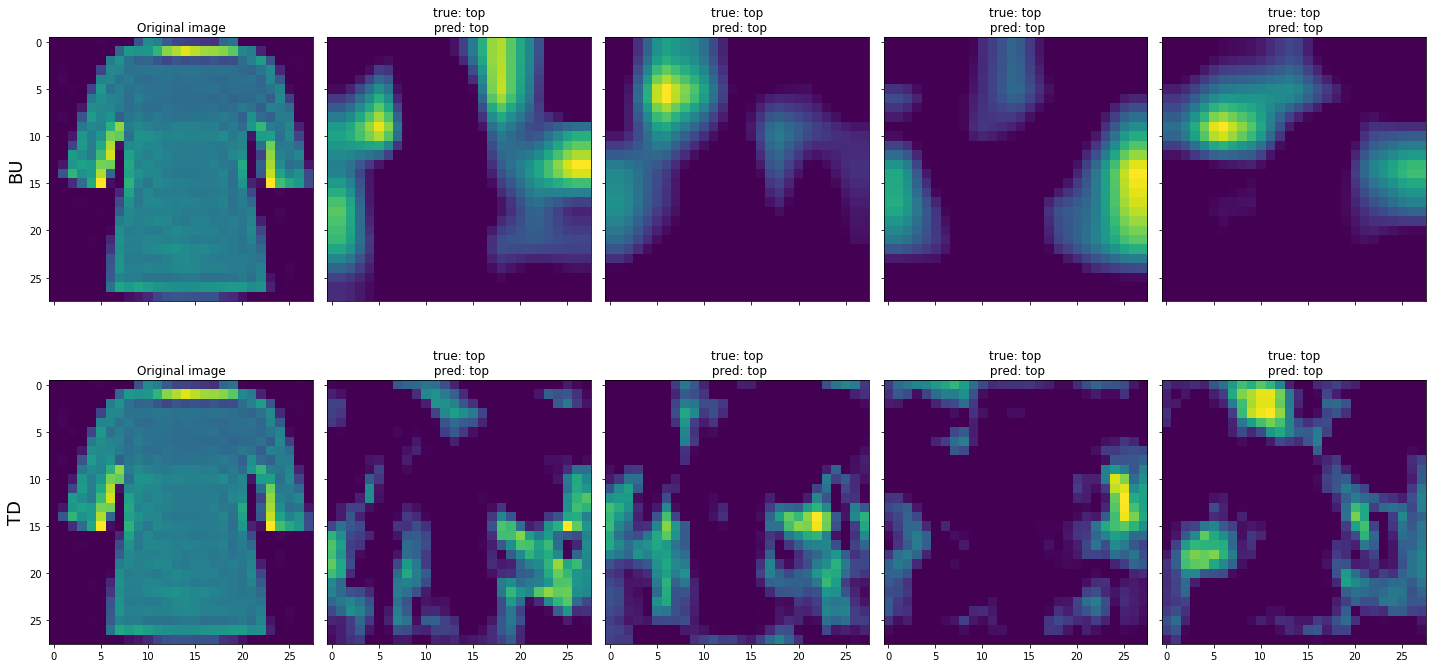

In [109]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 10),sharex=True, sharey=True)

mbu = 'NIN-light'
mtd = 'NIN-light_TD'
layer = 'act_4'

# ii = int(np.random.rand() * len(x_val))
# 上のコードと合わせる

ax[0,0].imshow(x_val[ii,:,:,0])
ax[1,0].imshow(x_val[ii,:,:,0])
ax[0,0].set_title("Original image")
ax[1,0].set_title("Original image")

for i in range(4):
    ax[0,i+1].imshow(gradcam[datasets[1]][mbu][i][layer][ii])
    ax[1,i+1].imshow(gradcam[datasets[1]][mtd][i][layer][ii])
    ax[0,0].set_ylabel("BU", fontsize=font_ylabel)
    ax[1,0].set_ylabel("TD", fontsize=font_ylabel)
    ax[0,i+1].set_title(f"true: {class_labels[y_val[ii]]}\n pred: {class_labels[y_pred[datasets[1]][mbu][i][ii]]}")
    ax[1,i+1].set_title(f"true: {class_labels[y_val[ii]]}\n pred: {class_labels[y_pred[datasets[1]][mtd][i][ii]]}")
fig.tight_layout()

# 手書きシャツの予測

In [110]:
# custom_objects={'tf': tf}
# →　カスタムオブジェクトまたはカスタムレイヤーを明示的に処理する必要があります。
model_TD = tf.keras.models.load_model(
    "./output/models/FMNIST/NIN_light_TD_it1.h5", custom_objects={'tf': tf})
model_BU = tf.keras.models.load_model(
    "./output/models/FMNIST/NIN_light_it1.h5", custom_objects={'tf': tf})

In [111]:
model_TD.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 7, 7, 1)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 7, 7, 48)     480         lambda_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 7, 7, 48)     192         conv2d_15[0][0]                  
____________________________________________________________________________________________

In [112]:
model_BU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 48)        1248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 48)        192       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 48)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 40)        1960      
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 40)        160       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 40)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 24)       

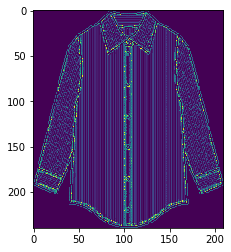

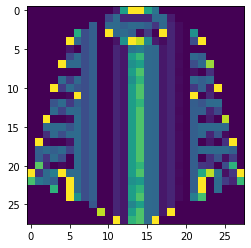

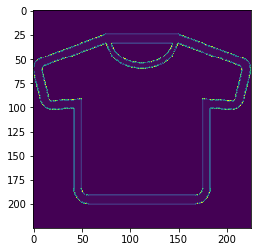

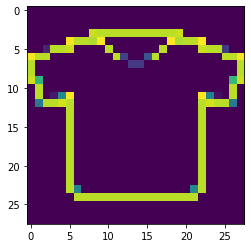

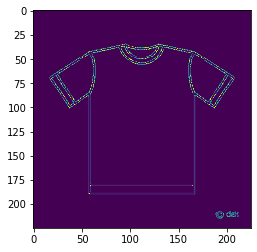

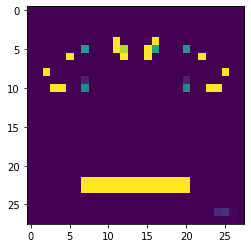

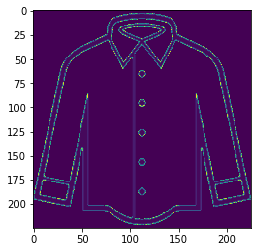

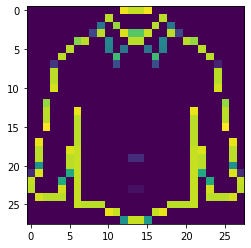

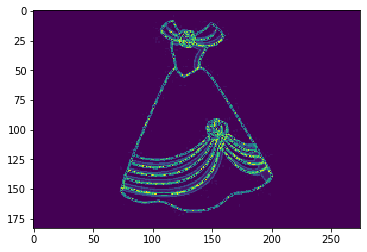

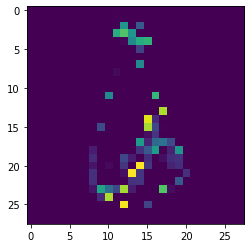

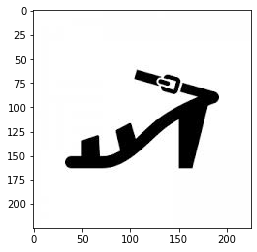

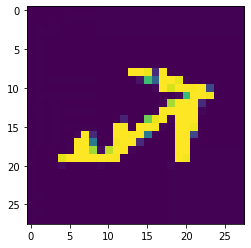

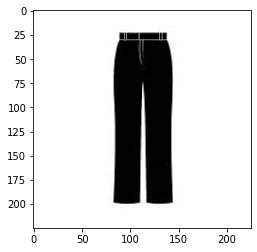

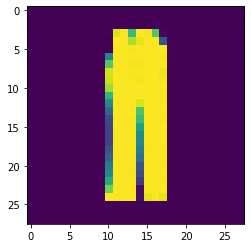

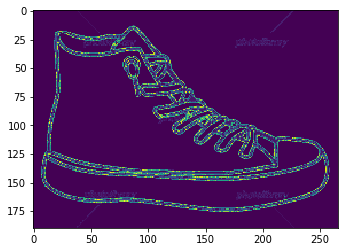

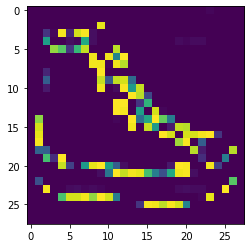

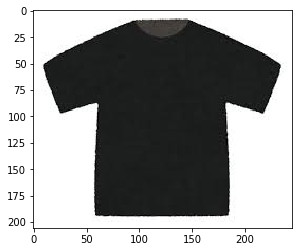

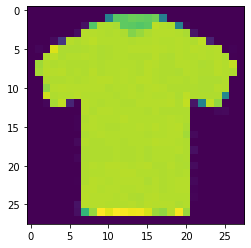

In [113]:
# 手書きフリー画像
path_test = './data/test'
flist_test = sorted(os.listdir(path_test))
del flist_test[0]
img_test = np.empty((0,28,28,1))
for img in flist_test:
    test = Image.open('./data/test/' + img)
    plt.imshow(np.array(test))
    plt.show()
    
    img = Image.open('./data/test/' + img).resize((28, 28))

    # 比率変更せずにリサイズ
#     img.thumbnail((28, 28), Image.BICUBIC)
#     left = 0
#     top = 28 - np.array(img).shape[1]
#     result = Image.new(img.mode, (28, 28))
#     result.paste(img, (left, top))
#     img = result.copy()
#     print(np.array(img).shape)
#     print(type(np.array(img)))
#     print(np.array(img).max())
#     print(np.array(img).min())
#     plt.imshow(np.array(img))
#     plt.show()
    
    # グレースケール化 (ガンマ補正)
#     img_max = np.array(img).max()
#     gamma22LUT  = [pow(x/img_max, 2.2)*img_max for x in range(256)] * 3
#     gamma045LUT = [pow(x/img_max, 1.0/2.2)*img_max for x in range(256)]
#     img_rgb = img.convert("RGB") # any format to RGB
#     img_rgbL = img_rgb.point(gamma22LUT)
#     img_grayL = img_rgbL.convert("L")  # RGB to L(grayscale)
#     img_gray = img_grayL.point(gamma045LUT)
#     img = img_gray
#     plt.imshow(np.array(img)/img_max)
#     plt.show()
#     print(np.array(img).shape)
#     print(type(np.array(img)))
    
    # 通常のグレースケール
    img = img.convert('L')
    # 白黒反転
    img = ImageOps.invert(img)
    # 画像表示
    plt.imshow(img)
    plt.show()
    
    img_max = np.array(img).max()
    img = (np.array(img)/img_max).reshape((1,28,28,1))
    img_test = np.concatenate([img_test, img], axis = 0)

'0':'T-shirt/top',
'1':'Trouser',
'2':'Pullover',
'3':'Dress',
'4':'Coat',
'5':'Sandal',
'6':'Shirt',
'7':'Sneaker',
'8':'Bag',
'9':'Ankle Boot',

In [114]:
y_test = np.array([0,0,0,0,0,0,1,0,0,0,
                   1,0,0,0,0,0,0,0,0,0,
                   1,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,1,0,0,0,
                   0,0,0,1,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,1,0,0,
                   1,0,0,0,0,0,0,0,0,0,
                   1,0,0,0,0,0,0,0,0,0,
                   1,0,0,0,0,0,0,0,0,0]
                 ).reshape((9,10)).astype(np.int)
# pred
score_TD= model_TD.evaluate(img_test, y_test, verbose=0)
score_BU= model_BU.evaluate(img_test, y_test, verbose=0)
# print('test loss:', score[0])
print('TD accuracy:', score_TD[1])
print('BU accuracy:', score_BU[1])

TD accuracy: 0.11111111
BU accuracy: 0.22222222


In [115]:
print(model_TD.predict(img_test).argmax(1))
print(model_BU.predict(img_test).argmax(1))
print()
print(model_TD.predict(img_test).argmax(1) == y_test.argmax(1))
print(model_BU.predict(img_test).argmax(1) == y_test.argmax(1))
print()
print(model_TD.predict(img_test)[-1].max())
print(model_BU.predict(img_test)[-1].max())
print()
print(model_TD.predict(img_test)[-1])
print(model_BU.predict(img_test)[-1])

[4 8 5 8 5 5 1 8 0]
[6 8 8 8 8 5 1 5 0]

[False False False False False False False False  True]
[ True False False False False False False False  True]

0.9817375
0.99016947

[9.8173749e-01 2.5087240e-06 9.8494189e-03 2.3864455e-05 1.4542196e-05
 5.8422379e-06 8.3175991e-03 1.6505379e-05 2.9217934e-05 3.0535782e-06]
[9.9016947e-01 6.9724970e-06 1.2572124e-03 3.0917072e-05 6.2441782e-06
 4.6160105e-05 8.3771646e-03 1.1550674e-05 8.8182373e-05 6.1595774e-06]


# 手書き予測 resnet
## Imagenette is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

In [116]:
# モデルをこちらで定義
def downscale_tf(x, down_factor=2):

    in_shape = x.shape[1:]

    x = tf.compat.v2.image.resize(x, tf.math.floordiv(in_shape[:-1], down_factor), method='gaussian', antialias=True)

    return x

In [117]:
# custom_objects={'downscale_tf': downscale_tf}　特殊な層をこのファイル上で定義する
resnet_TD = tf.keras.models.load_model(
    "./output/models/IMAGENETTE/ResNet18_TD.h5", custom_objects={'downscale_tf': downscale_tf})
resnet_BU = tf.keras.models.load_model(
    "./output/models/IMAGENETTE/ResNet18.h5")

In [118]:
resnet_TD.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 8, 8, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 256)    7168        lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16, 16, 3)    0           input_1[0][0]                    
______________________________________________________________________________________________

In [119]:
resnet_BU.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [121]:
npzfile = np.load("data.npz", allow_pickle=True)
x_train = npzfile['arr_0']
y_train = npzfile['arr_1']

In [122]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [149]:
n = 5200

5


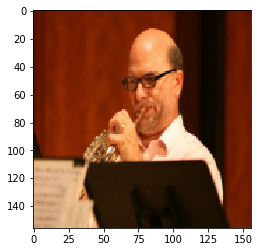

In [150]:
print(y_train[n])
plt.imshow(x_train[n])
plt.show()

In [125]:
# 元画像にノイズを入れる
def addGaussianNoise(src):
    row,col,ch= src.shape
    mean = 0
    var = 0.1
    sigma = np.sqrt(var)
#     gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = np.random.rand(row,col,ch)
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss
    print(gauss.min())
    print(gauss.max())
    return noisy

2.607448930358469e-05
0.9999704321843492


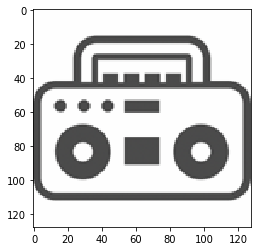

0.23459450938658255
1.0
0.0001146620087308925
0.9999795777135825


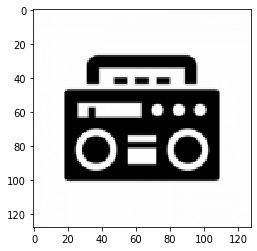

4.4789854529704974e-07
1.0
4.0765466924330696e-06
0.9999983971667435


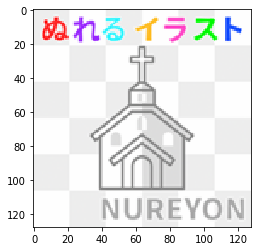

1.772439995204732e-05
1.0
1.0765688848612953e-05
0.9999507368357621


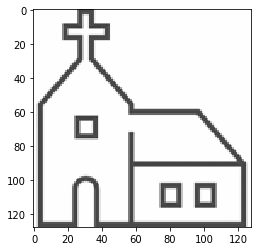

0.20462240580253907
1.0
1.0282190685440007e-05
0.9999982282459958


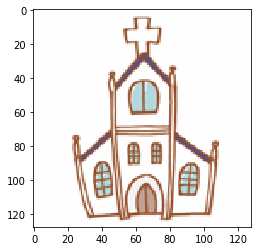

0.09403914813720152
1.0


In [126]:
# 手書きフリー画像
path_test = './data/test_resnet'
flist_test = sorted(os.listdir(path_test))
del flist_test[0]
img_test = np.empty((0,128,128,3))
for img in flist_test:
    # 元画像の確認
#     test = Image.open('./../notebooks/test_resnet/' + img)
#     plt.imshow(np.array(test))
#     plt.show()
    
    img = Image.open('./data/test_resnet/' + img)
#     .resize((128, 128))
    
    # RGBへ変換
    img = img.convert('RGB') 
#     比率変更せずにリサイズ
    img.thumbnail((128, 128), Image.BICUBIC)
    left = 0
    top = 128 - np.array(img).shape[1]
    result = Image.new(img.mode, (128, 128), (255, 255, 255))
    result.paste(img, (left, top))
    img = result.copy()
#     print(np.array(img).shape)
#     print(type(np.array(img)))
#     print(np.array(img).max())
#     print(np.array(img).min())
#     plt.imshow(np.array(img))
#     plt.show()
    
    # グレースケール化 (ガンマ補正)
#     img_max = np.array(img).max()
#     gamma22LUT  = [pow(x/img_max, 2.2)*img_max for x in range(256)] * 3
#     gamma045LUT = [pow(x/img_max, 1.0/2.2)*img_max for x in range(256)]
#     img_rgb = img.convert("RGB") # any format to RGB
#     img_rgbL = img_rgb.point(gamma22LUT)
#     img_grayL = img_rgbL.convert("L")  # RGB to L(grayscale)
#     img_gray = img_grayL.point(gamma045LUT)
#     img = img_gray
#     plt.imshow(np.array(img)/img_max)
#     plt.show()
#     print(np.array(img).shape)
#     print(type(np.array(img)))
    
    # 通常のグレースケール
#     img = img.convert('L')
    # 白黒反転
#     img = ImageOps.invert(img)
    
    img = np.array(img)
    # ノイス付加（ガウス？一様？）
    img = addGaussianNoise(img)
    # 正規化
    img = img/img.max()
    # 画像表示
    plt.imshow(img)
    plt.show()
    print(img.min())
    print(img.max())
    
    
    img = img.reshape((1,128,128,3))
    img_test = np.concatenate([img_test, img], axis = 0)

In [127]:
y_test = np.array([0,0,1,0,0,0,0,0,0,0,
                   0,0,1,0,0,0,0,0,0,0,
                   0,0,0,0,1,0,0,0,0,0,
                   0,0,0,0,1,0,0,0,0,0,
                   0,0,0,0,1,0,0,0,0,0]
                 ).reshape((5,10)).astype(np.int)
# pred
score_resnet_TD= resnet_TD.evaluate(img_test, y_test, verbose=0)
score_resnet_BU= resnet_BU.evaluate(img_test, y_test, verbose=0)
# print('test loss:', score[0])
print('TD accuracy:', score_resnet_TD[1])
print('BU accuracy:', score_resnet_BU[1])

TD accuracy: 0.6
BU accuracy: 1.0


In [128]:
print(resnet_TD.predict(img_test).argmax(1))
print(resnet_BU.predict(img_test).argmax(1))
print()
print(resnet_TD.predict(img_test).argmax(1) == y_test.argmax(1))
print(resnet_BU.predict(img_test).argmax(1) == y_test.argmax(1))
print()
print(resnet_TD.predict(img_test)[-1].max())
print(resnet_BU.predict(img_test)[-1].max())
print()
print(resnet_TD.predict(img_test)[-1])
print(resnet_BU.predict(img_test)[-1])

[2 2 4 2 5]
[2 2 4 4 4]

[ True  True  True False False]
[ True  True  True  True  True]

0.2976833
0.7542048

[1.0091665e-04 2.0747502e-04 2.3439196e-01 9.6396498e-02 2.1793847e-01
 2.9768330e-01 4.1054520e-03 5.2991204e-02 5.8434803e-02 3.7749965e-02]
[1.1922371e-04 2.6415806e-04 1.4993337e-01 6.7385472e-02 7.5420481e-01
 1.0569771e-02 6.9788992e-05 1.3765433e-02 1.8163148e-03 1.8716793e-03]


# 結果、考察
## クラスが少ないデータセットでは
### →TDとBUで差がない、手書き絵はBUも分類（むしろTDの方が悪い）
### 　しかし、バックグラウンドに市松模様などある場合TDで分類できる、BUは分類できない
### 　よって、バックグラウンドのテクスチャーに対してはTDが有効
### 　（そもそもクラスが少ないとテクスチャー情報を多くは必要としない？
## クラスの多い（分類に多くのテクスチャー情報が必要）imagenetでは手書き分類どうなる？
## ↓

In [137]:
# # from keras.applications.resnet50 import ResNet50
# # from keras.models import Sequential, Model
# # from keras.layers import Input, Flatten, Dense

# resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)

In [138]:
# resnet50.summary()

In [139]:
# # 手書きフリー画像
# # 画像サイズ大きいのでpil通常のリサイズ
# path_test = './data/imagenet'
# flist_test = sorted(os.listdir(path_test))
# del flist_test[0]
# print(flist_test)
# img_test = np.empty((0,224,224,3))
# for img in flist_test:
#     # 元画像の確認
# #     test = Image.open('./../notebooks/test_resnet/' + img)
# #     plt.imshow(np.array(test))
# #     plt.show()
    
#     img = Image.open('./data/imagenet/' + img).resize((224, 224))
    
#     # RGBへ変換
#     img = img.convert('RGB') 
# #     比率変更せずにリサイズ
# #     img.thumbnail((224, 224), Image.BICUBIC)
# #     left = 0
# #     top = 128 - np.array(img).shape[1]
# #     result = Image.new(img.mode, (224, 224), (255, 255, 255))
# #     result.paste(img, (left, top))
# #     img = result.copy()
    
# #     print(np.array(img).shape)
# #     print(type(np.array(img)))
# #     print(np.array(img).max())
# #     print(np.array(img).min())
# #     plt.imshow(np.array(img))
# #     plt.show()
    
#     # グレースケール化 (ガンマ補正)
# #     img_max = np.array(img).max()
# #     gamma22LUT  = [pow(x/img_max, 2.2)*img_max for x in range(256)] * 3
# #     gamma045LUT = [pow(x/img_max, 1.0/2.2)*img_max for x in range(256)]
# #     img_rgb = img.convert("RGB") # any format to RGB
# #     img_rgbL = img_rgb.point(gamma22LUT)
# #     img_grayL = img_rgbL.convert("L")  # RGB to L(grayscale)
# #     img_gray = img_grayL.point(gamma045LUT)
# #     img = img_gray
# #     plt.imshow(np.array(img)/img_max)
# #     plt.show()
# #     print(np.array(img).shape)
# #     print(type(np.array(img)))
    
#     # 通常のグレースケール
# #     img = img.convert('L')
#     # 白黒反転
# #     img = ImageOps.invert(img)
    
#     img = np.array(img)
#     # ノイス付加（ガウス？一様？）
#     img = addGaussianNoise(img)
#     # 正規化
#     img = img/img.max()
#     # 画像表示
#     plt.imshow(img)
#     plt.show()
#     print(img.min())
#     print(img.max())
#     print(img.shape)
    
#     img = img.reshape((1,224,224,3))
#     img_test = np.concatenate([img_test, img], axis = 0)

In [140]:
# resnet50.predict(img_test)[0][111]

In [141]:
# resnet50.predict(img_test)[0].max()

In [142]:
# y_test = np.zeros(2000)
# y_test[0] = 1
# y_test[1000] = 1
# y_test = y_test.reshape((2,1000)).astype(np.int)
# # pred
# score_resnet50= resnet50.evaluate(img_test, y_test, verbose=0)
# # print('test loss:', score[0])
# print('resnet50 accuracy:', score_resnet50[1])

In [143]:
# print(resnet50.predict(img_test).argmax(1))
# print()
# print(resnet50.predict(img_test).argmax(1) == y_test.argmax(1))
# print()
# print(resnet50.predict(img_test)[-1].max())
# print()
# print(resnet50.predict(img_test)[-1])